In [31]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [32]:
# 1d brownian motion (weiner process)
def brownian_motion(T, N):
    dt = T/N
    W = np.zeros(N)
    
    for i in range(1, N):
        W[i] = W[i-1] + np.random.normal()*np.sqrt(dt)
    
    return W

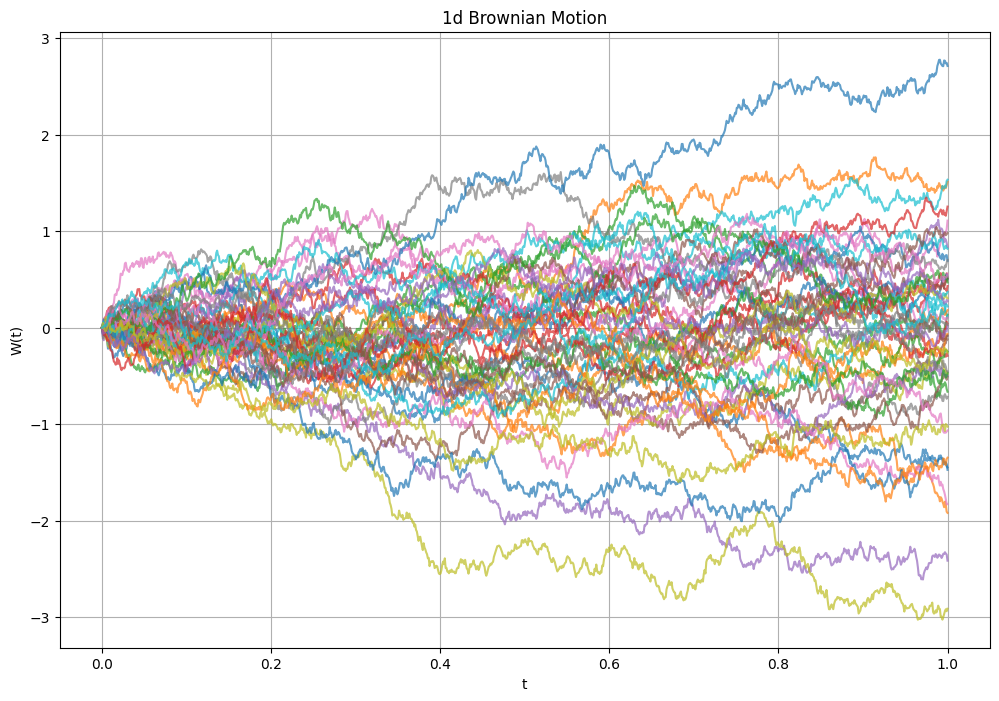

In [33]:
# simulate 100 brownian motions
t = np.linspace(0, 1, 1000)
plt.figure(figsize=(12, 8))
for i in range(50):
    plt.plot(t, brownian_motion(1, 1000), alpha=0.7)
    
plt.xlabel('t')
plt.ylabel('W(t)')
plt.title('1d Brownian Motion')
plt.grid()
plt.show()

In [58]:
def gbm(s_0, mu, sigma, T, N):
    s = np.zeros(N)
    W = brownian_motion(T, N)
    
    for i in range(N):
        s[i] = s_0*np.exp((mu - sigma**2/2)*i/N + sigma*W[i])
    
    return s

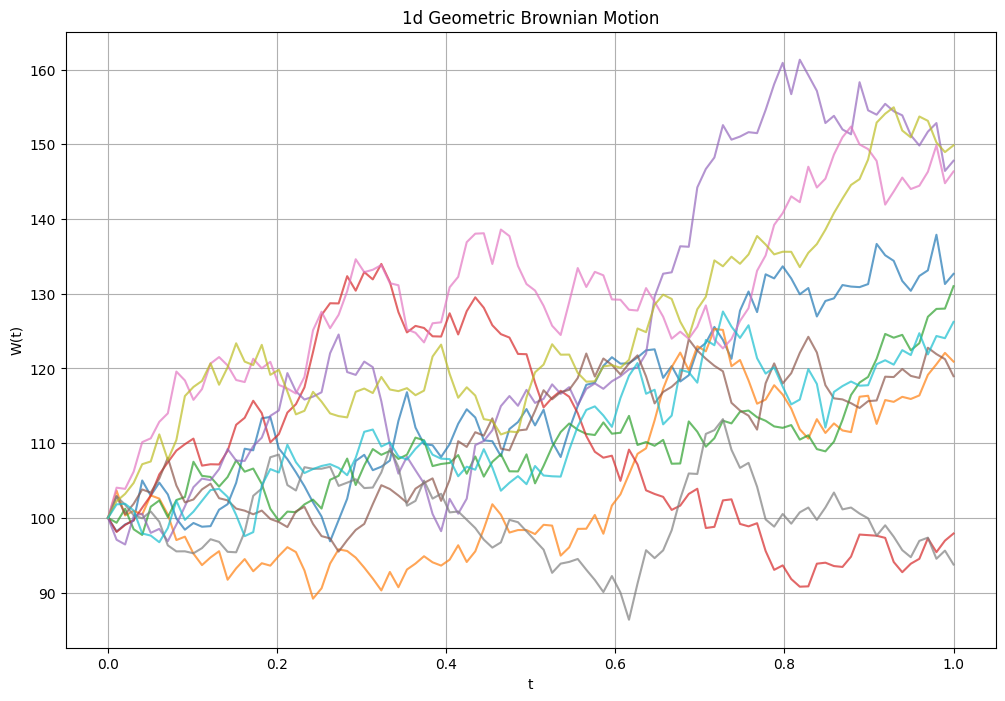

In [70]:
# simulate 100 geometric brownian motions
n = 100 # number of time steps
t = np.linspace(0, 1, n)
s_0 = 100 # initial stock price
mu = 0.1 # expected return (drift)
sigma = 0.2 # volatility (diffusion)

plt.figure(figsize=(12, 8))
for i in range(10):
    plt.plot(t, gbm(s_0, mu, sigma, 1, n), alpha=0.7)
    
plt.xlabel('t')
plt.ylabel('W(t)')
plt.title(
    '1d Geometric Brownian Motion'
)
plt.grid()
plt.show()